In [1]:
data_path = "/home/amorales/LC_test/training_set_rrl/"

In [2]:
%matplotlib notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from os.path import join
import ipywidgets as widgets
from IPython.display import display
import torch
import pickle

In [3]:
column_names_rrl = ["ID_VVV", "ID-OGLE", "dist_ogle-vvv", "KS_mag",
                    "1st_AOV_period", "2nd_AOV_period", "ID_OGLE", "OGLE_period"]
folders_names = ["o4_ecl_c_pmen1_vvv/","o4_ecl_nc_pmen1_vvv/","o4_ell_pmen1_vvv/","o4_rrab_vvv/","o4_rrc_vvv/"]
df_rrab = pd.read_csv(join(data_path, "o4_rrab.fnl"), 
                     delim_whitespace=True, comment='#', names=column_names_rrl)
df_rrc = pd.read_csv(join(data_path, "o4_rrc.fnl"), 
                     delim_whitespace=True, comment='#', names=column_names_rrl)
df_ecl_c = pd.read_csv(join(data_path, "o4_ecl_c_pmen1.fnl"), 
                     delim_whitespace=True, comment='#', names=column_names_rrl)
df_ecl_nc = pd.read_csv(join(data_path, "o4_ecl_nc_pmen1.fnl"), 
                     delim_whitespace=True, comment='#', names=column_names_rrl)
df_ell = pd.read_csv(join(data_path, "o4_ell_pmen1.fnl"), 
                     delim_whitespace=True, comment='#', names=column_names_rrl)
df_rrab["label"] = 3
df_rrc["label"] = 4
df_ecl_c["label"] = 0
df_ecl_nc["label"] = 1
df_ell["label"] = 2
display(df_ell.head())

,ID_VVV,ID-OGLE,dist_ogle-vvv,KS_mag,1st_AOV_period,2nd_AOV_period,ID_OGLE,OGLE_period,label
0,b221_302_5596,OGLE-BLG-ELL-024197,0.000019,13.62,0.6112,0.3056,OGLE-BLG-ELL-024197,0.611214,2
1,b221_306_5395,OGLE-BLG-ELL-024378,0.000006,12.78,0.3000,0.5999,OGLE-BLG-ELL-024378,0.599922,2
2,b233_201_5067,OGLE-BLG-ELL-018794,0.000009,14.14,0.3022,0.2624,OGLE-BLG-ELL-018794,0.302165,2
3,b233_402_7563,OGLE-BLG-ELL-019575,0.000020,14.41,0.3769,0.3170,OGLE-BLG-ELL-019575,0.376882,2
4,b234_310_9778,OGLE-BLG-ELL-000017,0.000003,13.39,0.2198,0.2470,OGLE-BLG-ELL-000017,0.219800,2


In [4]:
# Normalized, PhaseSorted, PhaseOffset
#import torch
from torch.utils.data import Dataset

class LightCurveRRL_Dataset(Dataset):
    def __init__(self, df_metadata, folder_name, transform=None):        
        self.data = list()
        self.name = df_metadata["ID_VVV"]
        self.period = df_metadata["OGLE_period"]
        self.label = torch.from_numpy(df_metadata["label"].values)
        self.transform = transform
        column_names_lc = ["mjd", "mag", "err"]
        column_names_fill = ["mjd", "mag", "err", "phase", "mask"]
        self.folder = folder_name
        #self.classes = ["T2C", "ECL"]
        df_zeros = pd.DataFrame(np.zeros((1, 5)),columns=column_names_fill)
                
        for i in range(len(df_metadata)):
            rrl_data = pd.read_csv(join(data_path, self.folder, self.name[i]+'.dat'), 
                                  header=None, delim_whitespace=True, comment='#', names=column_names_lc)
            #rrl_data.sort_values(by="mjd", inplace=True)
            rrl_data["phase"] = np.mod(rrl_data["mjd"], self.period[i])/self.period[i]
            #normalize
            mag_std = rrl_data["mag"].std()
            rrl_data["mjd"] = rrl_data["mjd"]-rrl_data["mjd"].min()
            rrl_data["mag"] = (rrl_data["mag"]-rrl_data["mag"].mean())/mag_std
            rrl_data["err"] = rrl_data["err"]/mag_std
            rrl_data["phase_offset"] = np.mod(rrl_data["mjd"]+np.random.random_sample()*self.period, self.period[i])/self.period[i]

            rrl_data.sort_values(by="phase", inplace=True)
            # ajustar todas a largo 335, rellenando con 0s las que sean mas pequeñas,
            # asignando un label '1' si es dato real y '0' si es dato rellenado.
            if len(rrl_data) == 335:
                rrl_data["mask"] = 1
            else:
                while len(rrl_data) < 335:
                    #RELLENAR con 0s;
                    rrl_data = rrl_data.append(df_zeros, ignore_index=True,sort=False)
            rrl_data = rrl_data.fillna(1)
            rrl_data = rrl_data[["phase","mag","err","mjd","mask","phase_offset"]]
            self.data.append(torch.from_numpy(rrl_data.values.astype('float32')))
            
    def __getitem__(self, idx):
        sample = {'data': self.data[idx], 'label': self.label[idx]}
        if self.transform:
            sample = self.transform(sample)
        return sample

    def getPeriod(self,idx):
        return self.period[idx]
    
    def plot(self, idx, ax):
        assert len(ax)==2, "Needs two subaxis"
        ax[0].cla()  
        ax[0].errorbar(self.data[idx][:, 0], self.data[idx][:, 1], self.data[idx][:, 2], fmt='.')
        ax[0].invert_yaxis()
        ax[1].cla()
        ax[1].errorbar(self.data[idx][:, 3], self.data[idx][:, 1], self.data[idx][:, 2], fmt='.')
        ax[1].invert_yaxis()
        ax[0].set_title("%d %s %0.4f" %(idx, self.name[idx],self.period[idx]))

    def __len__(self):
        return len(self.data)


In [18]:
# Magnitude Interpolation
#import torch
from torch.utils.data import Dataset

class LightCurveRRL_Dataset(Dataset):
    def __init__(self, df_metadata, folder_name, transform=None):        
        self.data = list()
        self.name = df_metadata["ID_VVV"]
        self.period = df_metadata["OGLE_period"]
        self.label = torch.from_numpy(df_metadata["label"].values)
        self.transform = transform
        column_names_lc = ["mjd", "mag", "err"]
        #column_names_fill = ["mjd", "mag", "err", "phase", "real"]
        self.folder = folder_name
        phi_interp = np.linspace(0, 1, num=100)
        #df_zeros = pd.DataFrame(np.zeros((1, 5)),columns=column_names_fill)
                
        for i in range(len(df_metadata)):
            rrl_data = pd.read_csv(join(data_path, self.folder, self.name[i]+'.dat'), 
                                  header=None, delim_whitespace=True, comment='#', names=column_names_lc)
            rrl_data["phase"] = np.mod(rrl_data["mjd"], self.period[i])/self.period[i]
            #normalize
            mag_std = rrl_data["mag"].std()
            rrl_data["mjd"] = rrl_data["mjd"]-rrl_data["mjd"].min()
            rrl_data["mag"] = (rrl_data["mag"]-rrl_data["mag"].mean())/mag_std
            rrl_data["err"] = rrl_data["err"]/mag_std
            rrl_data.sort_values(by="phase", inplace=True)
            # Interpolacion
            # ventaneo Gaussiano
            window = lambda phi_point : np.exp(-0.5*(phi_point-rrl_data["phase"])**2/0.03**2)
            # espaciado regular de 100 pts entre 0 y 1
            # cálculo de la interpolacion (prediccion) de la magnitud "basado en la cercania entre los puntos"
            mag_interp = np.array([np.sum(window(phi_val)*rrl_data["mag"])/np.sum(window(phi_val)) for phi_val in phi_interp])
            
            # orden cols: ['mjd','mag','err','phase']
            #self.data.append(torch.from_numpy(rrl_data.values.astype('float32')))
            self.data.append(torch.from_numpy(mag_interp.astype('float32')))
    def __getitem__(self, idx):
        sample = {'data': self.data[idx], 'label': self.label[idx].unsqueeze(0)}
        if self.transform:
            sample = self.transform(sample)
        return sample
  
    #def plot(self, idx, ax):
    #    assert len(ax)==2, "Needs two subaxis"
    #    ax[0].cla()  
    #    ax[0].errorbar(self.data[idx][:, 0], self.data[idx][:, 1], self.data[idx][:, 2], fmt='.')
    #    ax[0].invert_yaxis()
    #    ax[1].cla()
    #    ax[1].errorbar(self.data[idx][:, 3], self.data[idx][:, 1], self.data[idx][:, 2], fmt='.')
    #    ax[1].invert_yaxis()
    #    ax[0].set_title("%d %s %0.4f" %(idx, self.name[idx],self.period[idx]))

    def __len__(self):
        return len(self.data)


In [56]:
vvv_ecl_c = LightCurveRRL_Dataset(df_ecl_c, folders_names[0])

In [58]:
vvv_ecl_nc = LightCurveRRL_Dataset(df_ecl_nc, folders_names[1])

In [120]:
vvv_ell = LightCurveRRL_Dataset(df_ell, folders_names[2])

In [65]:
vvv_ell_ = LightCurveRRL_Dataset(df_ell, folders_names[2])

In [123]:
with open('PhaseSorted_NotInterp_ell.pkl', 'rb') as handle:
    vvv_ell = pickle.load(handle)
#label 2

In [57]:
vvv_rrab = LightCurveRRL_Dataset(df_rrab, folders_names[3])

In [55]:
vvv_rrc = LightCurveRRL_Dataset(df_rrc, folders_names[4])

In [5]:
vvv_rrc_offset = LightCurveRRL_Dataset(df_rrc, folders_names[4])

In [12]:
vvv_rrc_offset[420]['data'][:,0]

tensor([0.0462, 0.0508, 0.0541, 0.0677, 0.0679, 0.0796, 0.0819, 0.0851, 0.0901,
        0.0955, 0.0999, 0.1084, 0.1239, 0.1516, 0.1526, 0.1599, 0.1682, 0.1742,
        0.1803, 0.2318, 0.2369, 0.2405, 0.2424, 0.2610, 0.2680, 0.3802, 0.3877,
        0.3895, 0.3927, 0.3935, 0.4129, 0.4208, 0.4212, 0.4310, 0.4330, 0.4353,
        0.4656, 0.4659, 0.4711, 0.4749, 0.4764, 0.4995, 0.5254, 0.5510, 0.5599,
        0.5654, 0.5702, 0.5738, 0.5842, 0.5847, 0.6041, 0.6056, 0.6255, 0.6341,
        0.6395, 0.6414, 0.6584, 0.6600, 0.6790, 0.6871, 0.6896, 0.6956, 0.6999,
        0.7082, 0.7329, 0.7337, 0.7417, 0.7497, 0.7577, 0.7725, 0.8062, 0.8077,
        0.8132, 0.8465, 0.8499, 0.8584, 0.8700, 0.8730, 0.9353, 0.9415, 0.9507,
        0.9987, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 

In [39]:
#dataset
VVV = torch.utils.data.ConcatDataset([vvv_ecl_c, vvv_ecl_nc, vvv_ell,vvv_rrab, vvv_rrc])

In [66]:
classes = ('ECL_Contact', 'ECL_No-Contact', 'Ellipsoid','RRL_AB', 'RRL_C')


In [121]:
def plotea(datos1,datos2,ax,k,classes):
    n = sum(datos1[k]['data'][:,4] == 1)
    pha1 = datos1[k]['data'][:n,0]
    mag1 = datos1[k]['data'][:n,1]
    err1 = datos1[k]['data'][:n,2]
    pha2 = datos2[k]['data'][:n,0]
    mag2 = datos2[k]['data'][:n,1]
    err2 = datos2[k]['data'][:n,2]
    lab = datos1[k]['label'].item()
    [ax_.cla() for ax_ in ax]
    #ax.plot(phi, mag, lw=2, c='r')
    ax[0].errorbar(pha1,mag1,err1, fmt='.')
    ax[0].set_title("estrella tipo %s, k=%d" %(classes[lab],k))
    ax[0].invert_yaxis()
    ax[1].errorbar(pha2,mag2,err2, fmt='.')
    #ax[1].set_title("estrella tipo %s, k=%d" %(classes[lab],k))
    ax[1].invert_yaxis()
    plt.show()
  

<IPython.core.display.Javascript object>


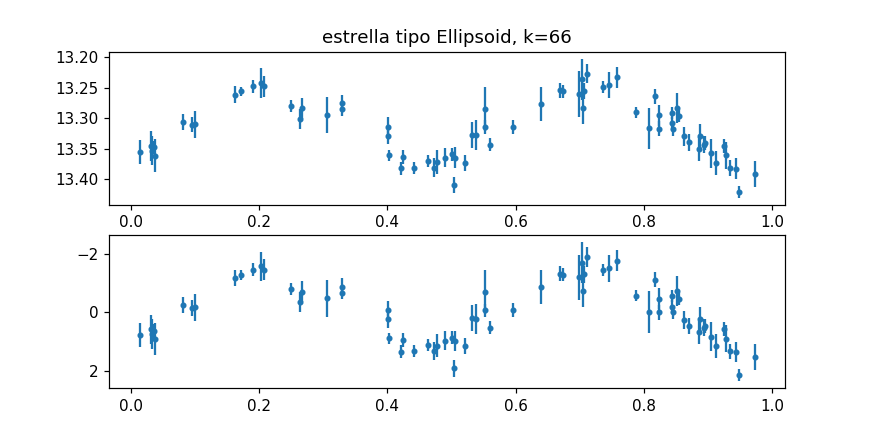

In [124]:
phi = np.linspace(0, 1, num=100)
largo = len(vvv_ell)
k = np.random.randint(largo)
fig,ax=plt.subplots(2,1,figsize=(8,4))
plotea(vvv_ell_,vvv_ell,ax,k,classes)
b1 = widgets.Button(description="Otra")
display(widgets.HBox([b1]))

def on_button_clicked(b):
    global k,largo
    if b.description == "Otra":
        k = np.random.randint(largo)
        #print(k)
        plotea(vvv_ell_,vvv_ell,ax,k,classes)
        #plotea(VVV_pha,k, ax,classes)

    
b1.on_click(on_button_clicked)

In [ ]:

k = 0
fig, ax = plt.subplots(2, 1, figsize=(6, 4), tight_layout=True)        
vvv_rrab.plot(k, ax)
b1 = widgets.Button(description="Prev")
b2 = widgets.Button(description="Next")
display(widgets.HBox([b1, b2]))

def on_button_clicked(b):
    global k
    if b.description == "Next":
        k +=1
    else:
        if k>0:
            k-=1
    vvv_rrab.plot(k, ax)

b1.on_click(on_button_clicked)
b2.on_click(on_button_clicked)

Guardar Pickles en vinagre

In [59]:
with open('PhaseSorted_NotInterp_ecl_c.pkl', 'wb') as handle:
    pickle.dump(vvv_ecl_c, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [60]:
with open('PhaseSorted_NotInterp_ecl_nc.pkl', 'wb') as handle:
    pickle.dump(vvv_ecl_nc, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [61]:
with open('PhaseSorted_NotInterp_ell.pkl', 'wb') as handle:
    pickle.dump(vvv_ell, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [62]:
with open('PhaseSorted_NotInterp_rrab.pkl', 'wb') as handle:
    pickle.dump(vvv_rrab, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [63]:
with open('PhaseSorted_NotInterp_rrc.pkl', 'wb') as handle:
    pickle.dump(vvv_rrc, handle, protocol=pickle.HIGHEST_PROTOCOL)